In [7]:
%load_ext autoreload
%autoreload 2
import torch
from torch import Tensor
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import numpy as np
import torch as t
import tqdm
#functional
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from functools import partial
import einops
import circuitsvis as cv
from src.game import Board, apply_best_moves, get_best_moves, generate_all_games, tree_walk
from typing import Optional, Any

# Graphing stuff

In [8]:
def to_numpy(tensor: Tensor, flat: bool=False):
    if type(tensor)!=torch.Tensor:
        return tensor
    if flat:
        return tensor.flatten().detach().cpu().numpy()
    else:
        return tensor.detach().cpu().numpy()

def imshow(tensor: Tensor, xaxis: Optional[str]=None, yaxis: Optional[str]=None, animation_name: str='Snapshot', **kwargs: Any):
    tensor = torch.squeeze(tensor)
    px.imshow(to_numpy(tensor, flat=False),aspect='auto', 
              labels={'x':xaxis, 'y':yaxis, 'animation_name':animation_name}, 
              **kwargs).show()
# Set default colour scheme
imshow = partial(imshow, color_continuous_scale='Blues')
# Creates good defaults for showing divergent colour scales (ie with both 
# positive and negative values, where 0 is white)
imshow_div = partial(imshow, color_continuous_scale='RdBu', color_continuous_midpoint=0.0)
# Presets a bunch of defaults to imshow to make it suitable for showing heatmaps 
# of activations with x axis being input 1 and y axis being input 2.
inputs_heatmap = partial(imshow, xaxis='Input 1', yaxis='Input 2', color_continuous_scale='RdBu', color_continuous_midpoint=0.0)

def line(x, y=None, hover=None, xaxis='', yaxis='', **kwargs):
    if type(y)==torch.Tensor:
        y = to_numpy(y, flat=True)
    if type(x)==torch.Tensor:
        x = to_numpy(x, flat=True)
    fig = px.line(x, y=y, hover_name=hover, **kwargs)
    fig.update_layout(xaxis_title=xaxis, yaxis_title=yaxis)
    fig.show()
def lines(lines_list, x=None, mode='lines', labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, **kwargs):
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show()

# Training Config Stuff

In [9]:
cfg = HookedTransformerConfig(
    n_layers = 8,
    n_heads = 8,
    d_model = 128,
    d_head = 16,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type='LN',
    d_vocab=11,
    d_vocab_out=10,
    n_ctx=10,
    init_weights=True,
    device="cuda",
    seed = 1337,
)

lr = 1e-5
weight_decay = 1e-4
test_train_split = 0.8
epochs = 40
batch_size = 8192



In [11]:
def generate_strat_games_data():
    board = [Board()]
    print('Generating stategic games...')
    games = apply_best_moves(board)
    print('Generated ' + str(len(games)) + ' games')
    moves = np.array([[10] + game.moves_played + [9] for game in games])
    print('Generated array of moves')
    return games, moves

def generate_all_games_data():
    board = [Board()]
    print('Generating all games...')
    games = generate_all_games(board)
    print('Generated ' + str(len(games)) + ' games')
    moves = np.array([[10] + game.moves_played + ([9] * (cfg.n_ctx - len(game.moves_played))) for game in games])
    print('Generated array of moves')
    return games, moves

def gen_data_labels(moves):
    data = np.array(moves[:, :-1])
    labels = moves[:, 1:]
    print('Generated data and labels')
    return data, labels

def gen_data_labels_one_hot(labels):
    encoded_labels = np.array(F.one_hot(t.tensor(labels)))
    print('One hot encoded labels')
    return encoded_labels

def train_test_split(data, encoded_labels, test_train_split=test_train_split):
    data = t.from_numpy(data)
    encoded_labels = t.from_numpy(encoded_labels).to(t.float)
    total_data = list(zip(data, encoded_labels))
    num_samples = len(total_data)
    train_size = int(test_train_split * num_samples)
    test_size = num_samples - train_size
    split_data = list(t.utils.data.random_split(total_data, [train_size, test_size]))
    train_pairs = split_data[0]
    test_pairs= split_data[1]
    train_data, train_labels = zip(*train_pairs)
    test_data, test_labels = zip(*test_pairs)

    train_data = t.stack(train_data).to(cfg.device)
    train_labels = t.stack(train_labels).to(cfg.device)
    test_data = t.stack(test_data).to(cfg.device)
    test_labels = t.stack(test_labels).to(cfg.device)

    print('Split data and labels into train and test sets')

    return train_data, train_labels, test_data, test_labels

def do_it_all(games_type):
    if games_type == 'all':
        _, moves = generate_all_games_data()
    elif games_type == 'strat':
        _, moves = generate_strat_games_data()
    data, labels = gen_data_labels(moves)
    encoded_labels = gen_data_labels_one_hot(labels)
    train_data, train_labels, test_data, test_labels = train_test_split(data, encoded_labels)
    return train_data, train_labels, test_data, test_labels

def loss_fn(logits: Tensor, labels: Tensor):
    return t.nn.functional.cross_entropy(logits, labels)

In [14]:
train_data, train_labels, test_data, test_labels = do_it_all('all')

Generating all games...
Generated 255168 games
Generated array of moves
Generated data and labels
One hot encoded labels
Split data and labels into train and test sets


In [15]:
train_losses = []
test_losses = []
# ALPHATOE
model = HookedTransformer(cfg).to(cfg.device)
optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# for epoch in tqdm.tqdm(range(epochs)):
for epoch in range(epochs):
    for batch in range(0, len(train_data), batch_size):
        train_logits = model(train_data[batch:batch+batch_size])
        train_loss = loss_fn(train_logits, train_labels[batch:batch+batch_size])

        train_loss.backward()

        train_losses.append(train_loss.item())
        optimizer.step()
        optimizer.zero_grad()

        with t.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

        print(f"Epoch {epoch} | Train Loss: {train_loss.item()} | Test Loss: {test_loss.item()}")

Moving model to device:  cuda
Epoch 0 | Train Loss: 2.344830274581909 | Test Loss: 2.332594633102417
Epoch 0 | Train Loss: 2.3320984840393066 | Test Loss: 2.3205134868621826
Epoch 0 | Train Loss: 2.3225040435791016 | Test Loss: 2.3088295459747314
Epoch 0 | Train Loss: 2.310490608215332 | Test Loss: 2.2975900173187256
Epoch 0 | Train Loss: 2.2986011505126953 | Test Loss: 2.286745548248291
Epoch 0 | Train Loss: 2.2869930267333984 | Test Loss: 2.2762386798858643
Epoch 0 | Train Loss: 2.276479482650757 | Test Loss: 2.2660486698150635
Epoch 0 | Train Loss: 2.270099401473999 | Test Loss: 2.2561492919921875
Epoch 0 | Train Loss: 2.2584052085876465 | Test Loss: 2.246514320373535
Epoch 0 | Train Loss: 2.245150327682495 | Test Loss: 2.237081289291382
Epoch 0 | Train Loss: 2.2365195751190186 | Test Loss: 2.227848768234253
Epoch 0 | Train Loss: 2.227893114089966 | Test Loss: 2.2188236713409424
Epoch 0 | Train Loss: 2.2197892665863037 | Test Loss: 2.2099697589874268
Epoch 0 | Train Loss: 2.21113085

In [4]:
model = HookedTransformer(cfg).to(cfg.device)

Moving model to device:  cuda


In [121]:
logits = model(t.tensor([10,4,8,1,7,6,2,5,3,0]))[0, -1]
probs = t.softmax(logits, dim=-1)

print(t.argmax(logits))




tensor(9, device='cuda:0')


In [5]:
t.save(model, 'model_no_games.pt')

In [29]:
model_load = torch.load('./model_good_games.pt')

In [32]:
print(t.max(model_load(t.tensor(seq_test))[0, -1]))

tensor(144.6259, device='cuda:0', grad_fn=<MaxBackward1>)


In [141]:
#lines([test_losses, train_losses])
#legend labels
lines([test_losses, train_losses], labels=['test', 'train'])

(0.0, 100.0)

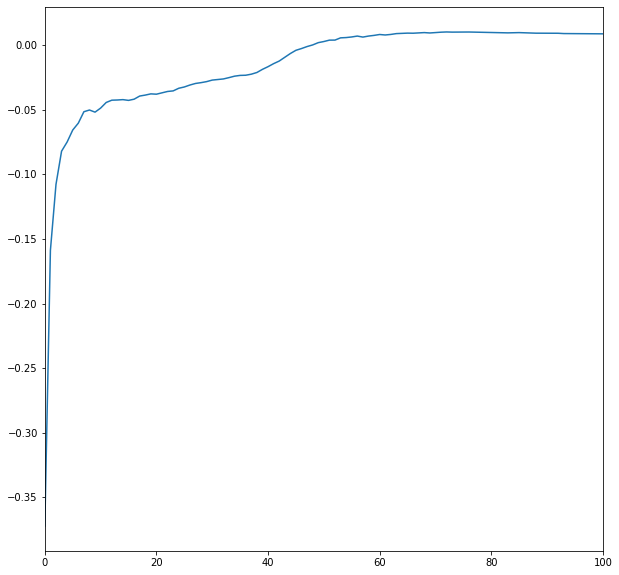

In [ ]:
#difference of lists test_losses and train_losses
diff = [test_losses[i] - train_losses[i] for i in range(len(test_losses))]
plt.figure(figsize=(10, 10))
plt.plot(diff)
#xlim
plt.xlim(0, 100)

In [ ]:
seq = t.tensor([10] * 10).to(cfg.device)
out = model(seq)

In [ ]:
out[:,-1,:]

tensor([[-68.5691, -53.3248, -33.7109,  28.4673, -47.1521,  49.8403,  20.7787,
          18.6870, -19.6562,  14.9037]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
line(test_losses, log_y=True)
# plt.plot(train_losses)

In [ ]:
line(train_losses, log_y=True)

In [122]:
imshow(model.embed.W_E)

In [123]:
# Take the dot product of all the embedding vectors
emb = model.embed.W_E
vec_count = emb.shape[0]
vec_dim = emb.shape[1]
print(f"The embedding shape is {emb.shape}, so our vectors of length {emb.shape[1]}")

dot_products = einops.einsum(emb, emb, "v2 embs, v1 emb -> v1 v2")

The embedding shape is torch.Size([11, 128]), so our vectors of length 128


In [124]:
print(dot_products.shape)
imshow_div(dot_products)

torch.Size([11, 11])


## What would your hypothesis around the attention head activations be based on seeing this?
+ Jack - My poorly informed guess is that tokens with low dot products and/or low norms won't have any strong attentional interaction
+ Omar - I think that corner moves [0, 2, 6, 8] will have similar attention patterns
+ Ari - I think same as Omar, plus center attends to everything, middle edges have attention symmetry too

In [137]:
tokens = [10,3,0,4,1,5]
# tokens = ([10] * 5) + [1,2,5,8,7]
str_tokens = [str(token) for token in tokens]
logits, cache = model.run_with_cache(torch.tensor(tokens).to('cuda'), remove_batch_dim=True)

print(type(cache))
attention_pattern = cache["pattern", 3, "attn"]
print(attention_pattern.shape)
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([8, 6, 6])


In [16]:
def sample_game(model: HookedTransformer, temp: float) -> list[int]:
    assert temp > 0
    seq = [10]
    #no grad
    with t.no_grad():
        for _ in range(8):
            logits = model(t.tensor(seq))[0, -1]
            probs = t.softmax(logits / temp, dim=0)
            token = t.multinomial(probs, num_samples=1).item()
            seq.append(token)
    return seq

In [17]:
def sample_games(model: HookedTransformer, temp: float, num_games: int) -> list[list[int]]:
    games=[]
    for _ in tqdm.tqdm(range(num_games)):
        games.append(sample_game(model, temp))
    return games


In [18]:
model_all_games = torch.load('./model_all_games.pt')
model_good_games = torch.load('./model_good_games.pt')
model_no_games = torch.load('./model_no_games.pt')

In [61]:
all_games_samples = sample_games(model_all_games, temp=1, num_games=1000)
good_games_samples = sample_games(model_good_games, temp=1, num_games=1000)
no_games_samples = sample_games(model_no_games, temp=1, num_games=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:28<00:00, 34.63it/s]


In [19]:
new_model_samples = sample_games(model, temp=1, num_games=1000)

100%|██████████| 1000/1000 [00:34<00:00, 29.09it/s]


In [23]:
def check_illegal_moves(game: list[int]) -> bool:
    clean_game = [token for token in game if token != 9]
    set_length = len(set(clean_game))
    return set_length == len(clean_game)

def check_illegal_moves_again(games: list[list[int]]) -> list[bool]:
    return [check_illegal_moves(game) for game in games]

In [24]:
def error_rate(games: list[list[int]]) -> float:
    return check_illegal_moves_again(games).count(False) / len(games)

In [25]:
print(f"Error rate for new model: {error_rate(new_model_samples)}")

Error rate for new model: 0.027


In [66]:
print(new_model_samples[9])
print(new_model_samples[99])

[10, 4, 1, 2, 3, 0, 5, 1, 8]
[10, 8, 2, 7, 0, 6, 0, 4, 5]


In [62]:
error_rate_all_games =  check_illegal_moves_again(all_games_samples).count(False)/ len(all_games_samples)
error_rate_good_games =  check_illegal_moves_again(good_games_samples).count(False)/ len(good_games_samples)
error_rate_no_games =  check_illegal_moves_again(no_games_samples).count(False)/ len(no_games_samples)

print(f"Error rate for all games: {error_rate_all_games}")
print(f"Error rate for good games: {error_rate_good_games}")
print(f"Error rate for no games: {error_rate_no_games}")


Error rate for all games: 1.0
Error rate for good games: 1.0
Error rate for no games: 0.973


In [63]:
print(all_games_samples[9])
print(all_games_samples[99])

[10, 3, 1, 7, 6, 3, 1, 0, 3]
[10, 3, 1, 7, 3, 6, 1, 0, 3]


In [91]:
logits = model_all_games(t.tensor([10, 3, 1]))[0, -1]
t.argmax(logits)
probs = t.softmax(logits, dim=0)

print(probs)

tensor([9.8593e-15, 6.2340e-11, 0.0000e+00, 9.1016e-09, 0.0000e+00, 5.3438e-36,
        1.0420e-11, 1.0000e+00, 1.5051e-34, 7.2200e-39], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [36]:
board = Board()

tree_entropy, games_seen = tree_walk(board)
print(tree_entropy)
print(games_seen)
print(tree_entropy/games_seen)

84700.8644382375
740170
0.1144343386495501
